# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install torchinfo

In [3]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [4]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 432778282.29it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28725561.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 209141508.30it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21872019.25it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Визуализируйте несколько картинок с соответствующими метками из датасета.

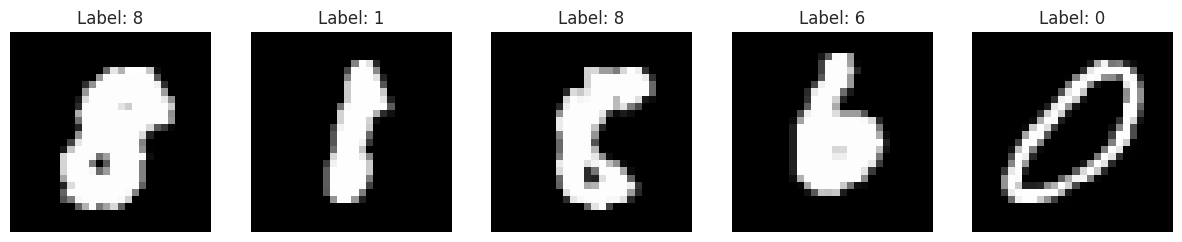

In [5]:
# Визуализируем несколько изображений с соответствующими метками
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        sample_idx = np.random.randint(len(dataset))
        image, label = dataset[sample_idx]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

visualize_samples(train_dataset)

Создайте генераторы батчей.

In [6]:
# Определение размера батча
batch_size = 64

# Создание генератора батчей для обучающего датасета
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Создание генератора батчей для валидационного датасета
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)


**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [58]:
simple_cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
simple_cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=21632, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
).to(device)
simple_cnn3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=10816, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
simple_cnn4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3200, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)
simple_cnn5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=10),
).to(device)
print(summary(simple_cnn1, input_size=(1, 1, 28, 28)))
print(summary(simple_cnn2, input_size=(1, 1, 28, 28)))
print(summary(simple_cnn3, input_size=(1, 1, 28, 28)))
print(summary(simple_cnn4, input_size=(1, 1, 28, 28)))
print(summary(simple_cnn5, input_size=(1, 1, 28, 28)))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [56]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "red"]
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))  # Увеличенный размер графика

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")
        axs[0].set_ylim(top=0.3)  # Применение ограничения по оси y
        axs[1].set_ylim(bottom = 0.94)

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

models = [simple_cnn1, simple_cnn2, simple_cnn3, simple_cnn4, simple_cnn5]
histories = {}

for i, model in enumerate(models, start=1):
    print(f"Training Model_{i}...")
    current_optimizer = optimizer(model.parameters())
    histories[f"history_cnn{i}"] = train(
        model,
        criterion,
        current_optimizer,
        train_batch_gen,
        val_batch_gen,
        num_epochs=20,
    )

    # Сохраняем веса модели в файл
    torch.save(model.state_dict(), f"simple_cnn{i}.pth")


Epoch 20 of 20 took 10.329 s
  training loss: 	0.006190
  validation loss: 	0.068604
  training accuracy: 			99.82 %
  validation accuracy: 			98.75 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

на следующем графике изобразим прогресс наших моделей \
для этого введем некоторые условные обозначения nC значит, что модель имеет n свёрточных слоев. nL - то же самое, но про линейные слои

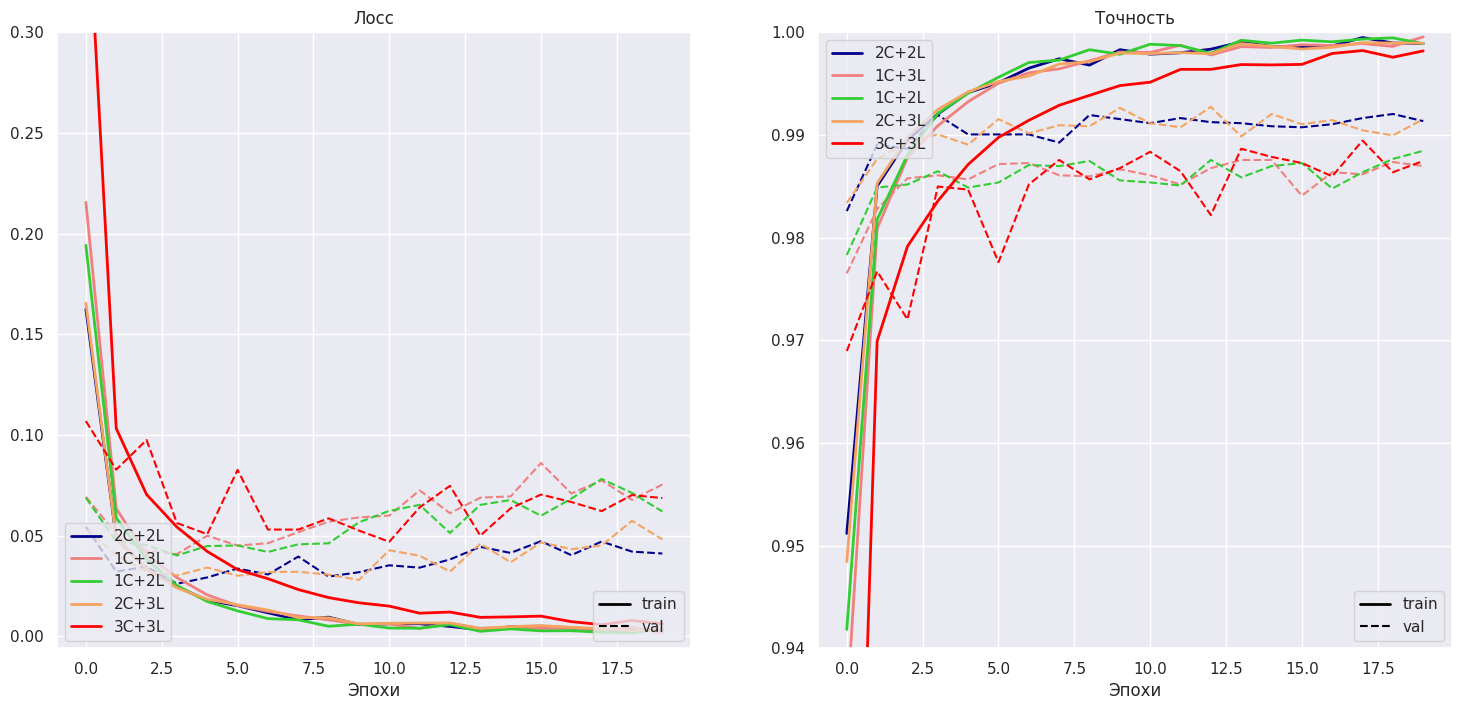

In [60]:
description = [
    '2C+2L',
    '1C+3L',
    '1C+2L',
    '2C+3L',
    '3C+3L'
]

plot_histories(
    [histories[f"history_cnn{i}"] for i in range(1, 6)],
    description
)

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**
как можно видеть, начиная с некоторой эпохи графики точности и лосса моделей почти стабилизировались \\
на графиках наблюдаются резкие колебания лосса, это может быть признаком переобучения, особенно если такие колебания не наблюдаются на обучающем наборе (что мы и можем заметить). Это может происходить из-за непредсказуемости модели, когда она начинает переучиваться на шум в данных. \\
также стоит отметить что увеличение числа слоев не всегда положительно складывается на обученной модели, существенно влияя на ее качество и время обучения: \\
Увеличение качества: Увеличение количества слоев может позволить модели извлекать более высокоуровневые и абстрактные признаки из данных, что может улучшить ее способность к обобщению и, следовательно, качество предсказаний.  \\
Ухудшение качества: Слишком большая глубина сети или неоптимальная архитектура может привести к переобучению, особенно если данных для обучения недостаточно. \\
Таким образом можно сделать вывод о наилучшей модели: \\
Оптимальное количество слоев зависит от конкретной задачи, доступных данных и вычислительных ресурсов. Идеальная модель должна иметь достаточную емкость для изучения сложных закономерностей в данных, но при этом не должна быть слишком сложной, чтобы избежать переобучения. \\
глядя на графики выше, наилучшей, по моему мнению, является модель cnn4, которая хоть и не сильно отличается значениями от остальных, но имеет наименьшие колебания лосса и точности

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [ ]:
cnn4_kernel_changed1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4608, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
cnn4_kernel_changed2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3200, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
cnn4_kernel_changed3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2048, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
cnn4_kernel_changed4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=6),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=6),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
cnn4_kernel_changed5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=8),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=128, kernel_size=8),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
).to(device)
summary(cnn4_kernel_changed1, input_size=(1, 1, 28, 28))
summary(cnn4_kernel_changed2, input_size=(1, 1, 28, 28))
summary(cnn4_kernel_changed3, input_size=(1, 1, 28, 28))
summary(cnn4_kernel_changed4, input_size=(1, 1, 28, 28))
summary(cnn4_kernel_changed5, input_size=(1, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 21, 21]           1,040
├─MaxPool2d: 1-2                         [1, 16, 10, 10]           --
├─ReLU: 1-3                              [1, 16, 10, 10]           --
├─Conv2d: 1-4                            [1, 128, 3, 3]            131,200
├─MaxPool2d: 1-5                         [1, 128, 1, 1]            --
├─ReLU: 1-6                              [1, 128, 1, 1]            --
├─Flatten: 1-7                           [1, 128]                  --
├─Linear: 1-8                            [1, 64]                   8,256
├─ReLU: 1-9                              [1, 64]                   --
├─Linear: 1-10                           [1, 10]                   650
Total params: 141,146
Trainable params: 141,146
Non-trainable params: 0
Total mult-adds (M): 1.65
Input size (MB): 0.00
Forward/backward pass s

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [ ]:
models = [cnn4_kernel_changed1, cnn4_kernel_changed2, cnn4_kernel_changed3, cnn4_kernel_changed4, cnn4_kernel_changed5]
histories_for4 = {}

for i, model in enumerate(models, start=1):
    print(f"Training Model_{i}...")
    current_optimizer = optimizer(model.parameters())
    histories_for4[f"history_cnn{i}"] = train(
        model,
        criterion,
        current_optimizer,
        train_batch_gen,
        val_batch_gen,
        num_epochs=20,
    )

    # Сохраняем веса модели в файл
    torch.save(model.state_dict(), f"simple_cnn{i}.pth")

Epoch 20 of 20 took 9.838 s
  training loss: 	0.007146
  validation loss: 	0.056749
  training accuracy: 			99.77 %
  validation accuracy: 			98.77 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

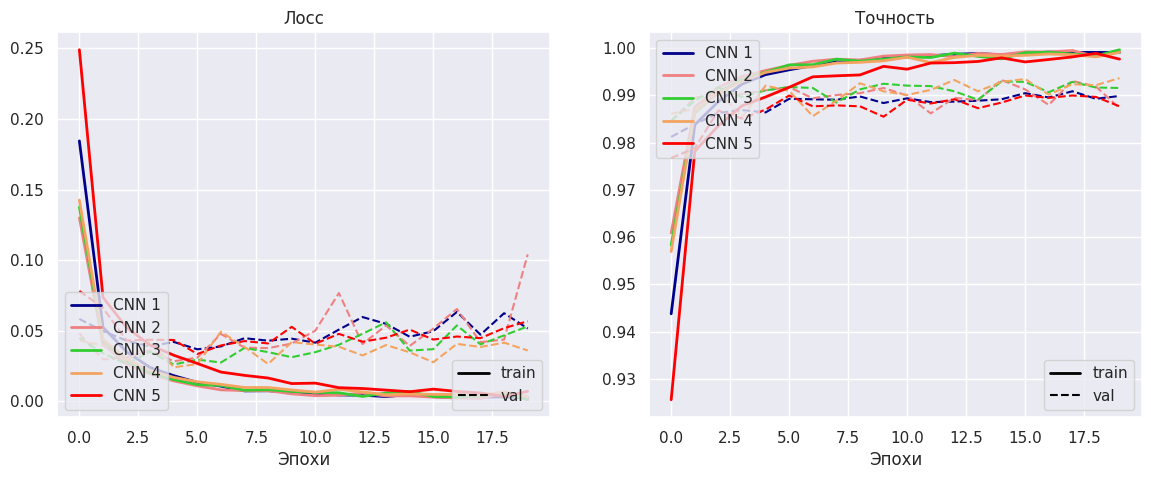

In [ ]:
plot_histories(
    [histories_for4[f"history_cnn{i}"] for i in range(1, 6)],
    [f"CNN {i}" for i in range(1, 6)]
)

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** \\
Влияние на качество: \\
Использование ядер свертки с большим размером позволяет модели извлекать более обобщенные признаки из изображений. Это может способствовать улучшению качества предсказаний модели, особенно на более сложных данных. \\
Однако, больший размер ядра также может привести к большему количеству параметров и увеличению времени обучения, особенно на более глубоких сетях. \\
Влияние на время обучения: \\
Использование ядер свертки с размером 5x5 увеличивает количество параметров модели и, как следствие, увеличивает время обучения. \\
Более крупные ядра требуют больше вычислительных ресурсов для свертки изображений, что приводит к дополнительным вычислительным затратам на каждой эпохе обучения. \\
в моем же случае лучшим вариантом будет ядро 6*6, т.к. на нем колебания наименьшие. Переобучения же наблюдаются на всех моделях, но у данного варианта оно визуально наименьшее

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [ ]:
best_val_accuracy = 0
best_model_name = ''

for i in range(1, 6):
    model_name = f"history_cnn{i}"
    val_accuracy = max(histories_for4[model_name]['acc']['val'])
    print(f"Model {i}: Validation Accuracy = {val_accuracy}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_name = model_name

print(f"\nThe best model is {best_model_name} with validation accuracy of {best_val_accuracy}.")


Model 1: Validation Accuracy = 0.990843949044586
Model 2: Validation Accuracy = 0.9932324840764332
Model 3: Validation Accuracy = 0.9929339171974523
Model 4: Validation Accuracy = 0.9936305732484076
Model 5: Validation Accuracy = 0.9899482484076433

The best model is history_cnn4 with validation accuracy of 0.9936305732484076.


Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [ ]:
# Создание словарей для подсчета правильных и неправильных предсказаний, а также общего количества изображений по классам
correct_counts = {i: 0 for i in range(10)}
total_counts = {i: 0 for i in range(10)}
incorrect_examples = []

# Проход по всем изображениям валидационного датасета
for image, label in val_dataset:
    with torch.no_grad():
        # Предсказание метки класса для изображения
        predicted_label = torch.argmax(cnn4_kernel_changed4(image.unsqueeze(0).to(device))).item()

        # Обновление счетчиков
        if predicted_label == label:
            correct_counts[label] += 1
        else:
            incorrect_examples.append((image.squeeze().cpu(), label, predicted_label))

        total_counts[label] += 1

# Вычисление точности на каждом классе
class_accuracies = {}
for i in range(10):
    if total_counts[i] > 0:
        class_accuracies[i] = correct_counts[i] / total_counts[i]
    else:
        class_accuracies[i] = 0.0

# Вывод результатов
for i in range(10):
    print(f"Class {i+1}: Accuracy = {100*class_accuracies[i]:.4f}")


Class 1: Accuracy = 99.7959
Class 2: Accuracy = 99.6476
Class 3: Accuracy = 98.6434
Class 4: Accuracy = 99.8020
Class 5: Accuracy = 99.6945
Class 6: Accuracy = 99.1031
Class 7: Accuracy = 99.1649
Class 8: Accuracy = 99.3191
Class 9: Accuracy = 99.6920
Class 10: Accuracy = 98.7116


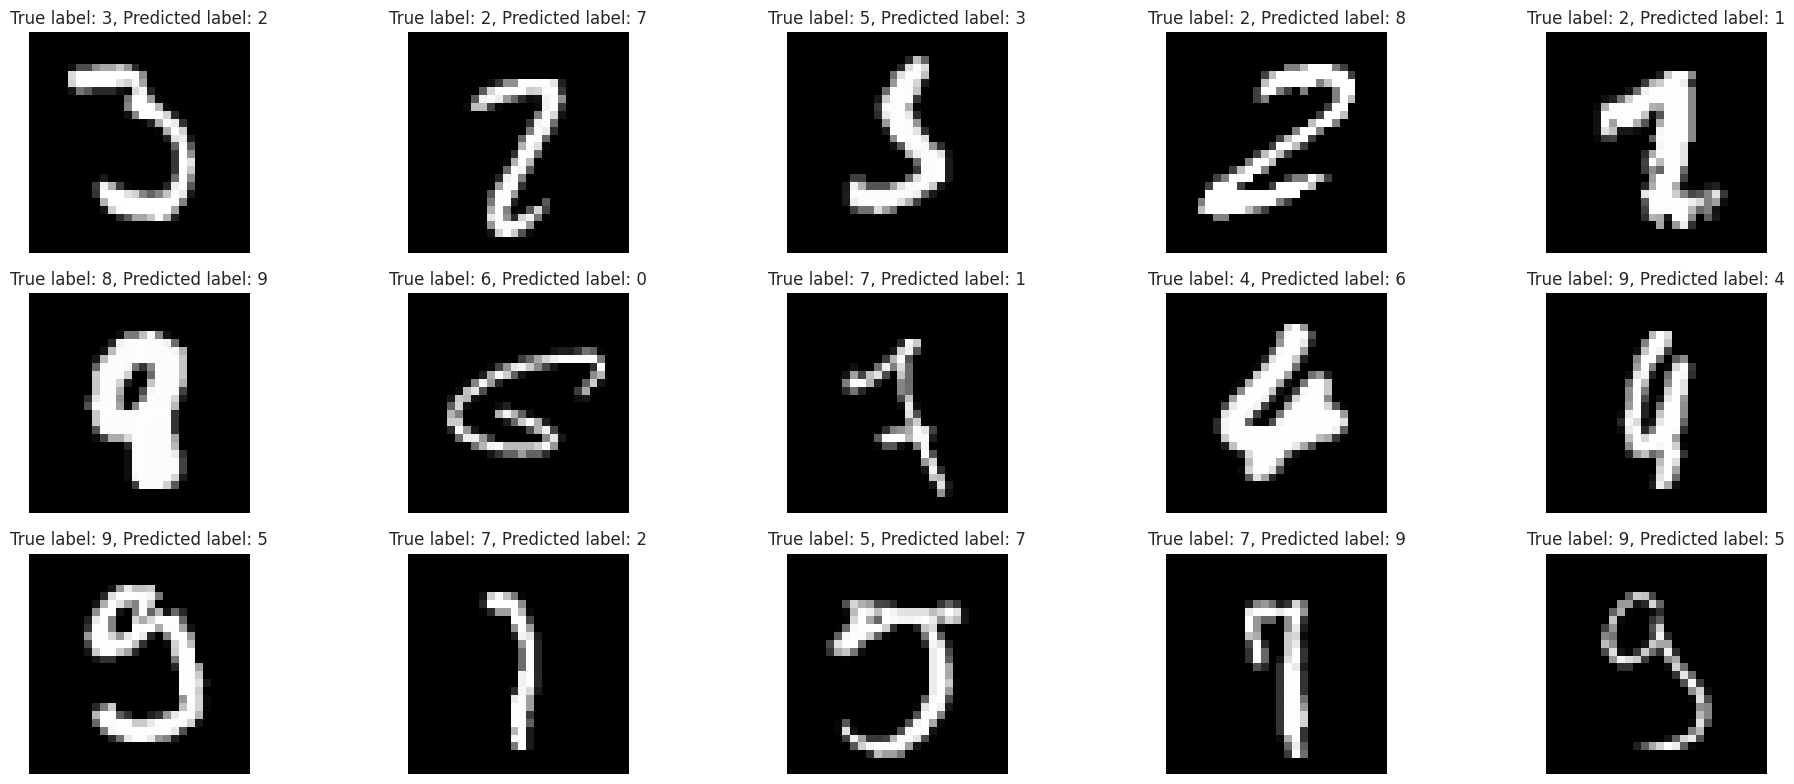

In [ ]:
import matplotlib.pyplot as plt

# Устанавливаем количество строк и столбцов для вывода
num_rows = 3
num_cols = 5
num_examples_to_show = num_rows * num_cols

# Создаем фигуру с заданным количеством строк и столбцов
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))

# Выводим несколько примеров неправильных предсказаний
for i in range(num_examples_to_show):
    image, true_label, predicted_label = incorrect_examples[i]

    # Рассчитываем индексы строки и столбца для текущего примера
    row_index = i // num_cols
    col_index = i % num_cols

    # Отображаем изображение в соответствующей ячейке
    axes[row_index, col_index].imshow(image, cmap='gray')
    axes[row_index, col_index].set_title(f'True label: {true_label}, Predicted label: {predicted_label}')
    axes[row_index, col_index].axis('off')

# Выводим графики
plt.tight_layout()
plt.show()


**Ответ:** \\
Исходя из вычисленных точностей для каждого класса, можно сказать, что точность модели почти равномерна по отношению к классам. Большинство классов имеют точность выше 99%, а отклонения в точности между классами незначительны. Таким образом, можно считать, что точность модели достаточно равномерна по отношению к классам. \\
также глядя на изображения, где моя модель допустила ошибки, можно сказать, что они вполне себе оправданы. В некоторых местах даже я бы предпочел вариант, выдвинутый моей нейронкой, правильному. Поэтому визуально моя нейросеть работает очень даже неплохо

**Вывод по всей задаче:** \\
Исследование проведено на моделях сверточных нейронных сетей с различными архитектурами, варьируя количество слоев и размеры ядер свертки. \\

Эксперимент 1 позволил выявить, что модель с архитектурой cnn4 показала наилучшие результаты по сравнению с другими моделями. Эта модель имеет наименьшие колебания в значениях функции потерь и точности на валидационном наборе данных, что указывает на более стабильное обучение. \\

В эксперименте 2 было обнаружено, что использование ядер свертки большего размера, в частности 6x6, позволяет извлекать более обобщенные признаки из изображений и ведет к более стабильному обучению модели. Однако это также может увеличить время обучения и количество параметров модели. \\

Проведенный анализ показал, что точность модели почти равномерна по отношению к классам, что свидетельствует о ее способности хорошо обобщать данные на всех классах. Отклонения в точности между классами незначительны, что указывает на высокую эффективность модели в распознавании различных цифр. \\

Ошибки модели, выявленные во время валидации, визуально обоснованы и несут в себе некоторую логику. В некоторых случаях предсказанные метки могут быть вполне разумными, даже если они отличаются от истинных. Это может говорить о том, что модель выявляет некоторые закономерности или характеристики, которые могут быть упущены человеческим глазом. \\

В целом, проведенный анализ позволяет сделать вывод о высокой эффективности сверточных нейронных сетей в задаче распознавания рукописных цифр на датасете MNIST. Улучшение качества модели может быть достигнуто путем подбора оптимальной архитектуры сети, включая количество слоев и размеры ядер свертки, а также тщательной настройки гиперпараметров и методов регуляризации.

---
### Задача 2. Перенос стиля

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [ ]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [ ]:
content_path = "/content/drive/MyDrive/DS/style_transfer_images/content"
style_path = "/content/drive/MyDrive/DS/style_transfer_images/style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 99.1MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=386785378304.0000, content_loss=      0.0000, style loss=386773620000.0000, tv loss=11760761.0000
L-BFGS | iteration: 100, total loss=2679943424.0000, content_loss=908941601.5625, style loss=1762738359.3750, tv loss=8263341.0000
L-BFGS | iteration: 200, total loss=1593635968.0000, content_loss=840985546.8750, style loss=744697207.0312, tv loss=7953303.0000
L-BFGS | iteration: 300, total loss=1380207488.0000, content_loss=810211328.1250, style loss=562218808.5938, tv loss=7777364.0000
L-BFGS | iteration: 400, total loss=1302806272.0000, content_loss=793278271.4844, style loss=501834960.9375, tv loss=7693097.0000
L-BFGS | iteration: 500, total loss=1262743168.0000, content_loss=782924902.3438, style loss=472157636.7188, tv loss=7660734.5000
L-BFGS | iteration: 600, total loss=1238164352.0000, content_loss=775738623.0469, style loss=454767187.5000, tv loss=7658458.0000
L-BFGS | iteration: 700, total loss=122097

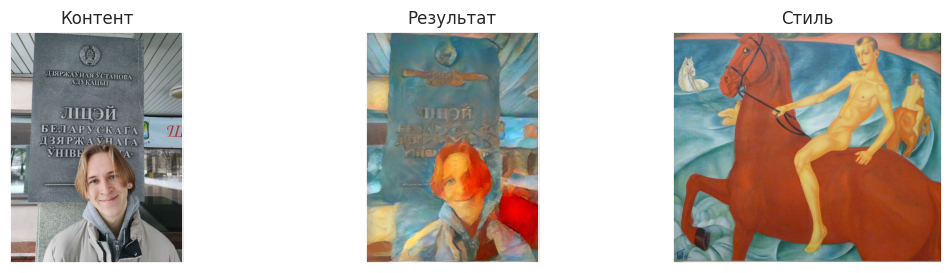

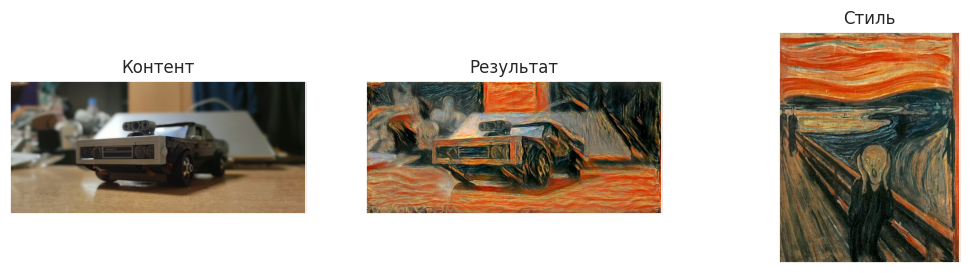

In [ ]:
# Сохраним результаты
!cp -r data/output-images /content/drive/MyDrive/DS

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.6 MB/s eta 0:00:00


In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prompt = " image of a Slavic guy with blue eyes, light brown long hair, wearing an earring, smiling in a white jacket against the background of a rectandle black marble plaque in the style and color palette of Petrov-Vodkin's painting Bathing of a Red Horse with dominant red and blue colors and a little bit blured, all image may be in red and blue colors"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['colors']
Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['colors']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

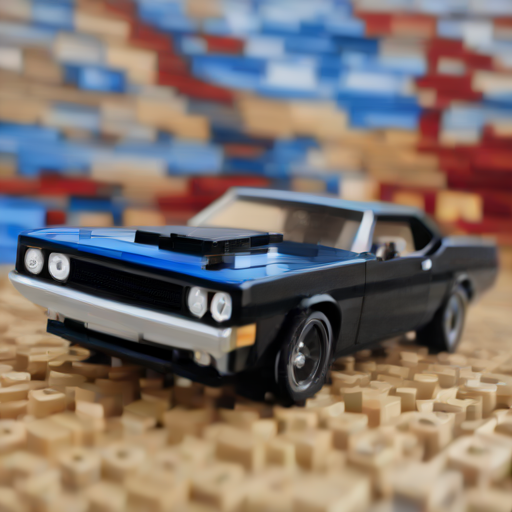

In [ ]:
prompt = "image of a black Dodge Challenger maid with Lego bricks car positioned at a 45-degree angle to the viewer in the style of Edvard Munch's painting 'The Scream', and image have to be maiden only in red, blue and black colors, having waves on all image and a little blured"

image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

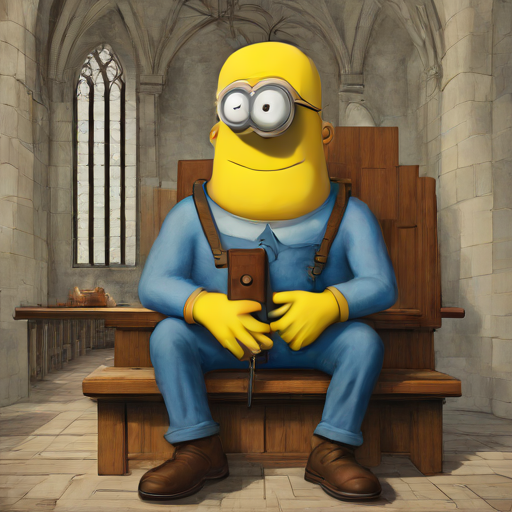

In [ ]:
prompt = "image of a very very very very muscular minion from the 'Despicable Me'i want to see all his muskular veins is praying with the Bible and a wooden cross in his hands in church, , in color palette of Grant Wood's painting 'American Gothic'. he is sitting in the church"

image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**
по правде говоря мне очень понравилось) \\
первая неройсеть сработала, на мой взгляд, безукоризненно. Изображения имеют общие черты и с оригиналом, и с картиной, которой они подражают \\
генерирующая же изображения диффузионная нейросеть работает не очень хорошо в неординарных промптов: это можно заметить на примере второй и третьей картинки. Рисунков и изображений автомобиля Dodge Challenger в интернете существует уйма, что нельзя сказать про накачанного миньона с крестом и Библией. Таким образом можно сделать вывод, что популярность запрашиваемых параметров в промпте напрямую влияет на качество полученного изображения \\
Из данной выборки я могу отметить второе изображение, которое уж очень сильно схоже для обоих нейросетей